Processing: 2011-05-04_exchange_rates_BND.json
Data:         date       EUR      GBP  USD       CNY        JPY  USD_vol  EUR_vol  \
0 2011-05-04  0.671952  0.60531  1.0  6.498694  81.050929      NaN      NaN   

   GBP_vol  JPY_vol  CNY_vol  
0      NaN      NaN      NaN  


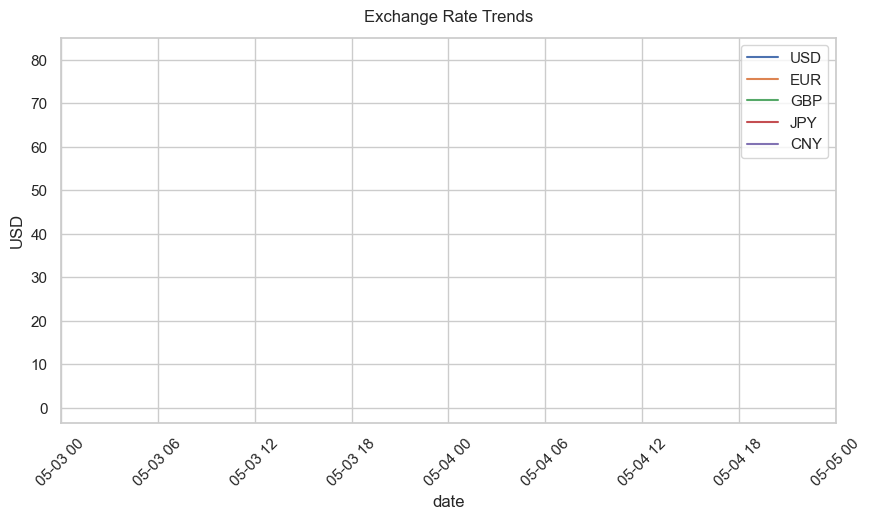

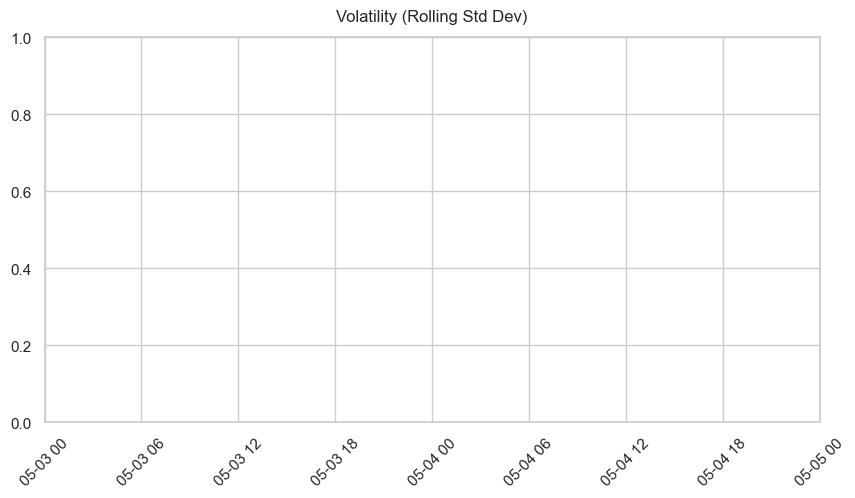

Volatile Periods: Empty DataFrame
Columns: [date, USD, EUR, GBP, JPY, CNY, USD_vol, EUR_vol, GBP_vol, JPY_vol, CNY_vol]
Index: []


In [ ]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

currencies = ["USD", "EUR", "GBP", "JPY", "CNY"]

data = []
for filename in os.listdir("."):
    if filename.endswith(".json"):
        date = filename.split("_exchange_rates_")[0]
        with open(os.path.join(".", filename)) as f:
            json_data = json.load(f)
            rates = {"date": date}
            items = json_data.get("channel", {}).get("item", [])
            if isinstance(items, dict): items = [items]
            for item in items:
                if item.get("targetCurrency") in currencies:
                    rates[item["targetCurrency"]] = float(item.get("exchangeRate", 1.0))
            if any(c in rates for c in currencies): data.append(rates)
df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])
if "USD" in df.columns: 
    for c in currencies: 
        if c in df.columns and c != "USD": df[c] = df[c] / df["USD"]
    df["USD"] = 1.0
for c in currencies: 
    if c in df.columns: df[f"{c}_vol"] = df[c].pct_change().rolling(3).std() * 100
print("Data:", df)

if not df.empty:
    plt.figure(figsize=(10, 5))
    for c in currencies:
        if c in df.columns and df[c].notna().any():
            sns.lineplot(x="date", y=c, data=df, label=c)
    plt.title("Exchange Rate Trends", y=1.02)
    if len(df) == 1: plt.xlim(df["date"].min() - pd.Timedelta(days=1), df["date"].max() + pd.Timedelta(days=1))
    plt.show()

    available = [c for c in currencies if c in df.columns and df[c].notna().any()]
    if len(df) > 1 and available:
        sns.pairplot(df[available])
        plt.suptitle("Pairwise Relationships", y=1.02)
        plt.show()
        sns.heatmap(df[available].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title("Correlation Matrix", y=1.02)
        plt.show()

    plt.figure(figsize=(10, 5))
    for c in currencies:
        if f"{c}_vol" in df.columns and df[f"{c}_vol"].notna().any():
            sns.lineplot(x="date", y=f"{c}_vol", data=df, label=c)
    plt.title("Volatility", y=1.02)
    if len(df) == 1: plt.xlim(df["date"].min() - pd.Timedelta(days=1), df["date"].max() + pd.Timedelta(days=1))
    plt.show()

    vol_cols = [f"{c}_vol" for c in currencies if f"{c}_vol" in df.columns]
    if vol_cols:
        volatile = df[df[vol_cols].gt(1.0).any(axis=1)]
        print("Volatile Periods:", volatile[["date"] + available + vol_cols])